### Stock Recommendation System with Reinforcement Learning - Data Simulation

In [3]:
import pandas as pd
import numpy as np
import random
from alpha_vantage.timeseries import TimeSeries
import time
import pandas as pd
from functools import reduce

In [ ]:
# -----------------------------
# Data Simulation
# -----------------------------
def fetch_price_data(tickers, start="2020-01-01", end="2025-04-01", batch_size=10, sleep_time=3):
    """Download historical close prices from Yahoo Finance including train + test period"""
    import time
    from yfinance import download
    all_data = []
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        try:
            print(f"Downloading batch {i//batch_size + 1}: {batch}")
            data = download(batch, start=start, end=end, progress=False, threads=False)["Close"]
            if isinstance(data, pd.Series):  # only one ticker
                data = data.to_frame()
            all_data.append(data)
        except Exception as e:
            print(f"Failed batch {batch}: {e}")
        time.sleep(sleep_time)
    return pd.concat(all_data, axis=1)
    # price_data = yf.download(tickers, start=start, end=end, progress=False, threads=False)["Close"]
    # return price_data

def simulate_transactions(price_data, num_users=1000, styles=None):
    """Generate simulated user transaction records with style changes and aligned dates"""
    actions = ['BUY', 'SELL']
    records = []
    available_dates = price_data.index[price_data.notna().any(axis=1)]

    for user_id in range(1, num_users + 1):
        num_records = np.random.randint(30, 60)  # longer user history
        if len(available_dates) < num_records:
            continue  # skip if not enough dates

        chosen_dates = np.random.choice(available_dates, size=num_records, replace=False)
        chosen_dates.sort()

        current_style = np.random.choice(list(styles.keys()))

        for i, date in enumerate(chosen_dates):
            if i > 0 and np.random.rand() < 0.2:
                current_style = np.random.choice(list(styles.keys()))

            stock_pool = [s for s in styles[current_style] if s in price_data.columns and not price_data[s].dropna().empty]
            if not stock_pool:
                continue

            stock = np.random.choice(stock_pool)
            if pd.isna(price_data.loc[date, stock]):
                continue

            price = price_data.loc[date, stock]
            action = np.random.choice(actions)
            shares = np.random.randint(1, 50)

            records.append([user_id, i, date, current_style, stock, action, shares, price])

    df = pd.DataFrame(
        records,
        columns=['User_ID', 'Step', 'Date', 'Style', 'Stock', 'Action', 'Shares', 'Price']
    )
    return df

def compute_market_features(df):
    """Calculate market-related characteristics for trading data (by stocks)"""
    df = df.sort_values(by=["Stock", "Date"]).copy()
    df["Daily_Return"] = df.groupby("Stock")["Price"].pct_change()
    df["Volatility"] = df.groupby("Stock")["Price"].rolling(5).std().reset_index(0, drop=True)
    df["Momentum"] = df.groupby("Stock")["Price"].diff(3)
    df["MA_10"] = df.groupby("Stock")["Price"].rolling(10).mean().reset_index(0, drop=True)
    df["Volatility_10"] = df.groupby("Stock")["Price"].rolling(10).std().reset_index(0, drop=True)
    return df

def assign_risk_preference(df):
    """Map user styles to numerical risk preferences"""
    preference_map = {
        "growth": 1.2,
        "value": 1.0,
        "conservative": 0.8,
        "trader": 1.5
    }
    df["Risk_Preference"] = df["Style"].map(preference_map)
    return df

def generate_user_data(num_users=1000, tickers=None, styles=None, price_data=None, save_path="simulated_transactions.csv"):
    """Main function to generate simulated data"""
    if price_data is None:
        price_data = fetch_price_data(tickers)
    df = simulate_transactions(price_data, num_users, styles)
    df = compute_market_features(df)
    df = assign_risk_preference(df)
    # df.to_csv(save_path, index=False)
    return df

In [ ]:
def fetch_price_data_alphavantage(tickers, api_key, start_date="2020-01-01", end_date="2025-04-01", sleep_time=15):
    """Fetch historical daily close prices using Alpha Vantage API."""
    ts = TimeSeries(key=api_key, output_format='pandas')
    all_series = []

    for ticker in tickers:
        try:
            print(f"Downloading: {ticker}")
            data, meta = ts.get_daily(symbol=ticker, outputsize='full')
            data = data.rename(columns={'4. close': ticker})
            data = data[[ticker]]
            data.index = pd.to_datetime(data.index)
            data = data.sort_index()
            data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
            all_series.append(data)
        except Exception as e:
            print(f"Failed to download {ticker}: {e}")
        time.sleep(sleep_time)  # avoid rate limit

    if not all_series:
        raise ValueError("No data fetched from Alpha Vantage.")

    combined = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), all_series)
    return combined

In [1]:
# Stock categories
blue_chip_stocks = ["AAPL", "MSFT", "JNJ", "V", "JPM", "PG", "UNH", "HD", "XOM", "KO"]
growth_stocks = ["TSLA", "NVDA", "AMZN", "META", "SHOP", "NFLX", "AMD", "CRWD", "DDOG", "PLTR"]
midcap_tech = ["UBER", "ABNB", "ROKU", "ZS", "OKTA", "SNOW", "MDB", "NET", "DOCU", "BILL"]
dividend_value = ["T", "VZ", "PFE", "CVX", "WMT", "MCD", "PEP", "MMM", "IBM", "KO"]
cyclical_industrials = ["CAT", "DE", "BA", "HON", "GE", "F", "GM", "LMT", "NOC", "UPS"]

# Initial style mapping
raw_styles = {
    "growth": growth_stocks + ["GE", "F", "GM"],
    "value": blue_chip_stocks + ["CAT", "HON"],
    "conservative": dividend_value + ["MMM", "UPS"],
    "trader": midcap_tech + ["DE", "BA", "LMT", "NOC"]
}

# Combine all tickers and fetch valid stocks
all_tickers = list(set(growth_stocks + blue_chip_stocks + dividend_value + midcap_tech + cyclical_industrials))

In [ ]:
# 1st
api_key = ""
tickers = all_tickers # ["AAPL", "MSFT", "TSLA", "JPM", "V", "KO"]
price_data_full = fetch_price_data_alphavantage(tickers, api_key)
price_data_full.to_csv("price_data_part1.csv")
# 2nd
remaining = [t for t in tickers if t not in price_data_full.columns]
new_api_key = ""
remaining_data = fetch_price_data_alphavantage(remaining, api_key=new_api_key)
remaining_data.to_csv("price_data_part2.csv")

In [ ]:
all_price_data = pd.concat([price_data_full, remaining_data], axis=1)
all_price_data.to_csv("price_data.csv")

/var/folders/kn/9r3myhg55x35j8l73dq6kw6c0000gn/T/ipykernel_17094/3424631759.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), ncol=1, fontsize="small")


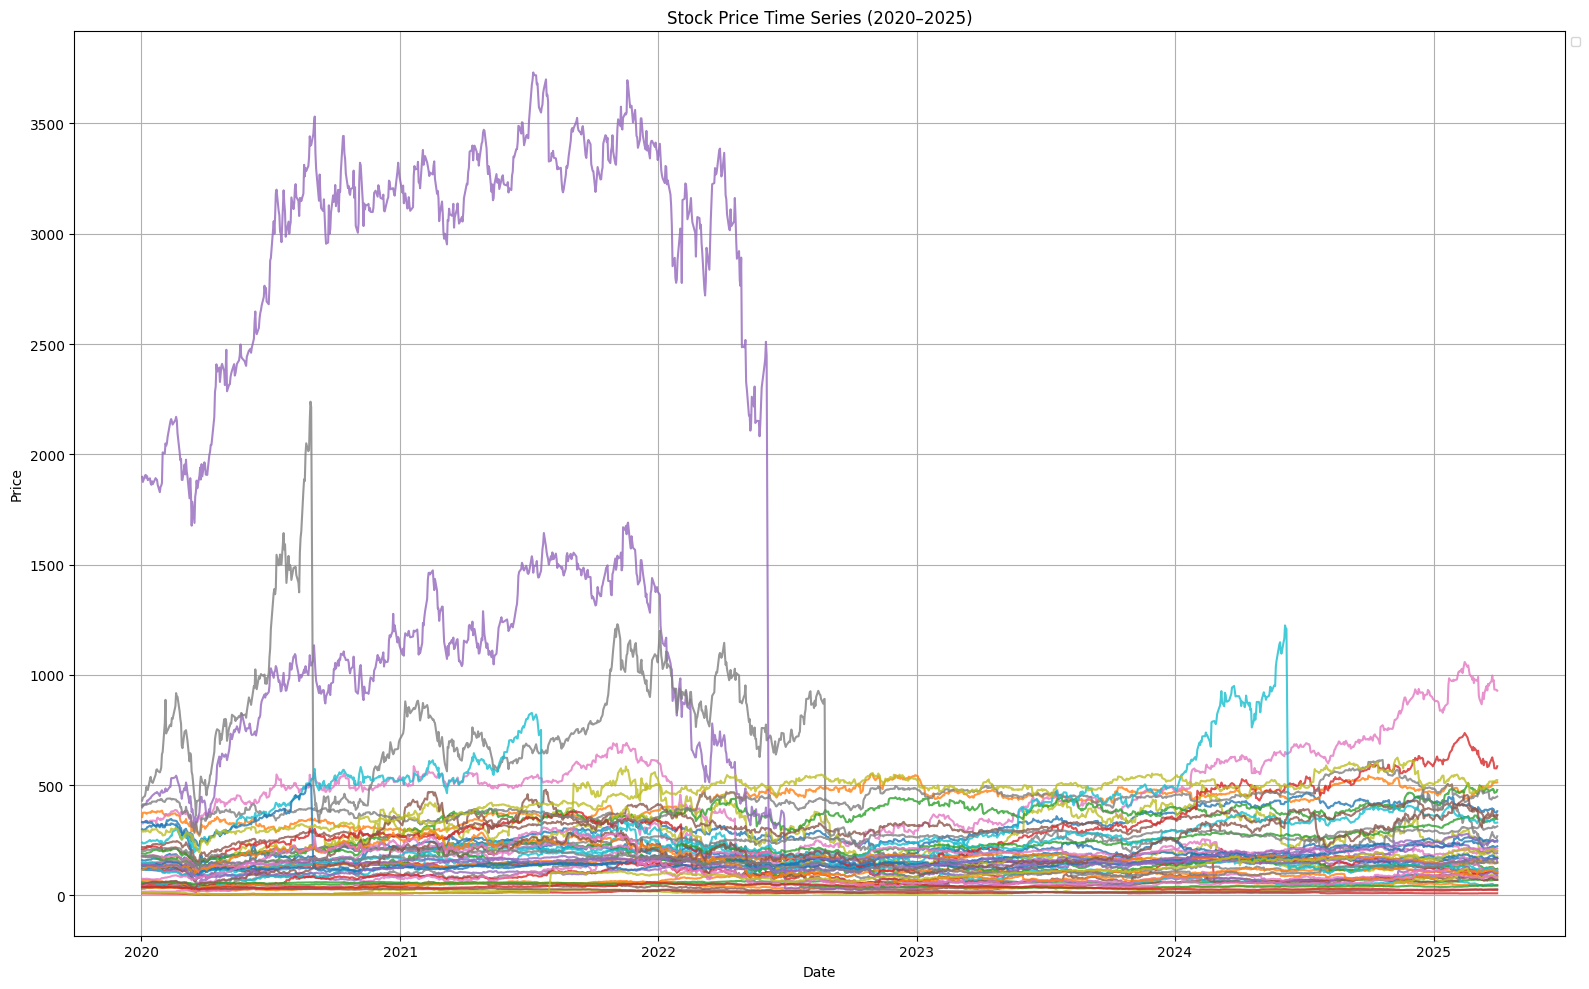

In [ ]:
# -----------------------------
# Stock Price Time Series (Appendix section B)
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

for stock in all_price_data.columns:
    plt.plot(all_price_data.index, all_price_data[stock], alpha=0.8)

plt.title("Stock Price Time Series (2020–2025)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="upper left", bbox_to_anchor=(1.0, 1.0), ncol=1, fontsize="small")
plt.tight_layout()
plt.grid(True)
plt.show()

In [4]:
# Load data
all_price_data = pd.read_csv("price_data.csv")

In [14]:
valid_stocks = set(all_price_data.columns) - {"Date"}

# Filter styles to ensure only stocks with data are used
styles = {
    style: [s for s in stock_list if s in valid_stocks]
    for style, stock_list in raw_styles.items()
}

# Final tickers list
tickers = list(valid_stocks)

In [15]:
df = generate_user_data(num_users=10000, price_data=all_price_data, tickers=tickers, styles=styles)

In [83]:
df.describe()

,User_ID,Step,Date,Shares,Price,Daily_Return,Volatility,Momentum,MA_10,Volatility_10,Risk_Preference
count,440766.000000,440766.000000,440766,440766.000000,440766.000000,440717.000000,440570.000000,440619.000000,440325.000000,440325.000000,440766.000000
mean,5009.470696,22.706872,2022-08-21 12:47:15.855760128,25.016621,214.421616,0.000120,1.120806,0.007907,214.437540,2.011305,1.119884
min,1.000000,0.000000,2020-01-02 00:00:00,1.000000,4.010000,-0.949003,0.000000,-2322.210000,4.010000,0.000000,0.800000
25%,2518.000000,11.000000,2021-05-05 00:00:00,13.000000,77.670000,0.000000,0.000000,0.000000,77.674000,0.222051,0.800000
50%,5021.000000,22.000000,2022-08-23 00:00:00,25.000000,151.700000,0.000000,0.093113,0.000000,151.740000,0.768043,1.000000
75%,7495.000000,33.000000,2023-12-08 00:00:00,37.000000,238.840000,0.000000,0.952565,0.000000,238.735000,1.947017,1.200000
max,10000.000000,58.000000,2025-04-01 00:00:00,49.000000,3731.410000,6.768340,1271.926800,375.880000,3731.410000,1223.912134,1.500000
std,2880.265181,14.115317,NaN,14.141642,315.085514,0.015183,6.042754,10.646418,315.060826,8.080218,0.257927


In [85]:
df.columns

Index(['User_ID', 'Step', 'Date', 'Style', 'Stock', 'Action', 'Shares',
       'Price', 'Daily_Return', 'Volatility', 'Momentum', 'MA_10',
       'Volatility_10', 'Risk_Preference'],
      dtype='object')

In [10]:
df.to_csv("data.csv", index=False)